<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/malariaPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteXNJCSM/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpg30sjvk9tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
# dataset = tf.data.Dataset.range(10)
# print(list(dataset.as_numpy_iterator()))

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Dataset Visualization


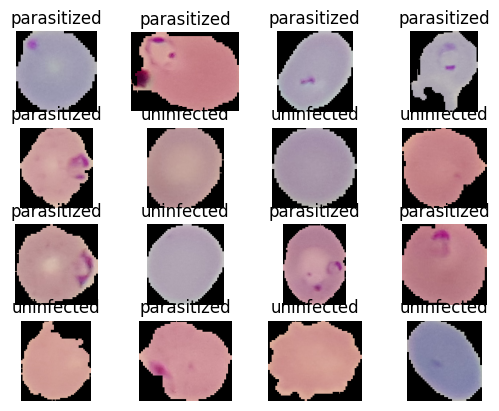

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [7]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing

In [8]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset
# val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
val_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

# Squential API Model

In [13]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Flatten(),
    Dense(1000, activation = "relu"),
    BatchNormalization(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),

])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Functional API Model

In [14]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")

feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [15]:
# Creating my feature extractor using a sequential model
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

])
feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [16]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)
x = Flatten()(x)
x = Dense(1000, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_8 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 100)               100100    
                                                       

# Model subclassing

In [17]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)

    self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [18]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)
x = Flatten()(x)
x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [19]:
# self, filters, kernel_size, strides, padding, activation, pool_size

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

# Custom Layers

In [20]:
from IPython.core.events import pre_execute
# , initializer = "random_normal"
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), trainable=True)
    self.b = self.add_weight(shape = (self.output_units,), trainable=True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if self.activation == "relu":
      return tf.nn.relu(pre_output)
    elif self.activation == "sigmoid":
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [21]:
IM_SIZE =224
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Flatten(),
    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),

])
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [22]:
# self, filters, kernel_size, strides, padding, activation, pool_size

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [23]:
IM_SIZE = 224
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Flatten(),
    Dense(1000, activation = "relu"),
    BatchNormalization(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),

])
lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_26 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_27 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

# Error Sunctioning

In [24]:
# We generally use BinaryCrossEntropy loss
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy() # from_logits=True
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [25]:
#  metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
#                 BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [26]:
from keras.api._v2.keras import metrics
from keras.src.losses import BinaryCrossentropy
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
lenet_model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = BinaryCrossentropy(),
                    metrics = metrics)
              # metrics = RootMeanSquaredError()

# Callbacks

In [52]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch + 1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch + 1, logs))

# CSVLogger

In [55]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [53]:
history = lenet_model.fit(train_dataset, epochs = 3, verbose = 1, callbacks = [LossCallback(),])

Epoch 1/3

 For Batch Number 1 the model has a loss of {'loss': 0.6239879131317139, 'tp': 5.0, 'fp': 6.0, 'tn': 15.0, 'fn': 6.0, 'accuracy': 0.625, 'precision': 0.4545454680919647, 'recall': 0.4545454680919647, 'auc': 0.7186146974563599} 
  1/689 [..............................] - ETA: 2:06 - loss: 0.6240 - tp: 5.0000 - fp: 6.0000 - tn: 15.0000 - fn: 6.0000 - accuracy: 0.6250 - precision: 0.4545 - recall: 0.4545 - auc: 0.7186
 For Batch Number 2 the model has a loss of {'loss': 0.6897897720336914, 'tp': 15.0, 'fp': 10.0, 'tn': 23.0, 'fn': 16.0, 'accuracy': 0.59375, 'precision': 0.6000000238418579, 'recall': 0.4838709533214569, 'auc': 0.6060605645179749} 
  2/689 [..............................] - ETA: 47s - loss: 0.6898 - tp: 15.0000 - fp: 10.0000 - tn: 23.0000 - fn: 16.0000 - accuracy: 0.5938 - precision: 0.6000 - recall: 0.4839 - auc: 0.6061
 For Batch Number 3 the model has a loss of {'loss': 0.6541883945465088, 'tp': 24.0, 'fp': 13.0, 'tn': 37.0, 'fn': 22.0, 'accuracy': 0.635416686

Model evaluation and testing

In [28]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 25s 5ms/step - loss: 366205.4375 - tp: 1323.0000 - fp: 1332.0000 - tn: 61.0000 - fn: 41.0000 - accuracy: 0.5020 - precision: 0.4983 - recall: 0.9699 - auc: 0.5072


[366205.4375,
 1323.0,
 1332.0,
 61.0,
 41.0,
 0.5019949078559875,
 0.498305082321167,
 0.9699413776397705,
 0.5072140693664551]

In [30]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

# Visualizing Confusion Matrix

In [31]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [32]:
print(np.array(inp).shape)
print(np.array(inp)[:, 0, ...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [33]:
print(labels)
labels = np.array([i[0] for i in labels])
print(labels)

[array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), arr

In [42]:
predicted = lenet_model.predict(np.array(inp)[:, 0, ...])

87/87 [==============================] - 1s 14ms/step


In [35]:
print(predicted[:, 0].shape)
print(predicted[:, 0])

(2757,)
[1. 1. 1. ... 1. 1. 1.]


[[  61 1329]
 [  42 1325]]


Text(0.5, 58.7222222222222, 'Predicted')

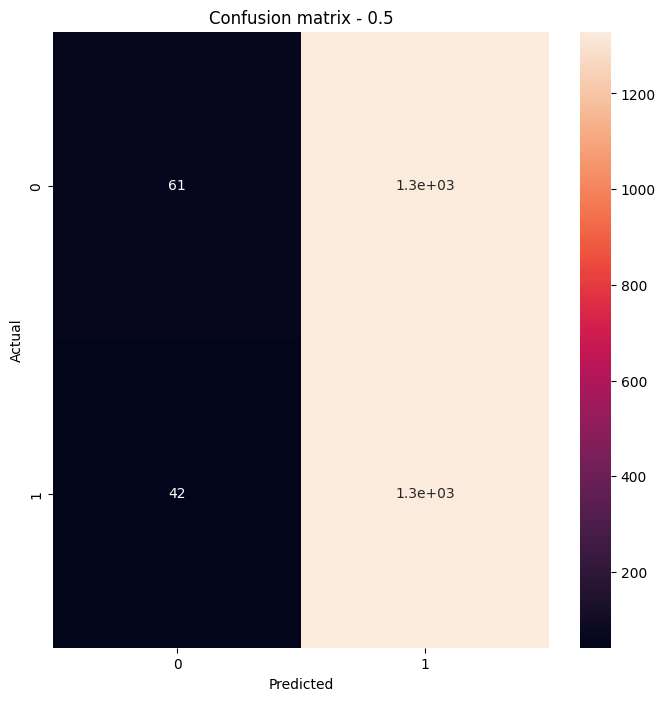

In [43]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC plot

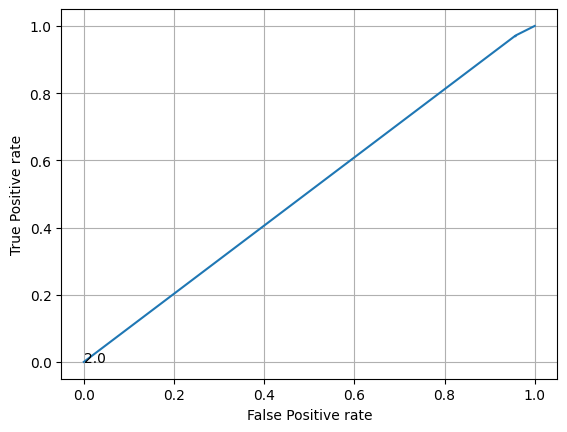

In [46]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

In [37]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 10s 10s/step


'U'

1/1 [==============================] - 0s 93ms/step


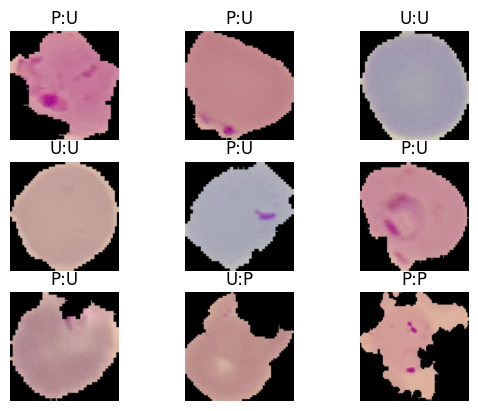

In [38]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')